In [1]:
import dask
import dask.dataframe as dd
from dask.distributed import Client, progress
import matplotlib.pyplot as plt

# Start Dask Client for Dashboard

#Starting the Dask Client is optional. It will provide a dashboard which is useful to gain insight on the computation.\
The link to the dashboard will become visible when we create the client below. We recommend having it open on one side of your screen while using your notebook on the other side. This can take some effort to arrange your windows, but seeing them both at the same is very useful when learning.

In [2]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
client

Client Scheduler: tcp://127.0.0.1:58872 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 1.86 GiB


#Dask Dataframes can read and store data in many of the same formats as Pandas dataframes. In this task, we read and write tsv format.

In [3]:
df_dask = dd.read_csv('Data/test_data.tsv',sep=r'\t')
df_dask

/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/io/csv.py:531: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  head = reader(BytesIO(b_sample), **kwargs)


,product_id,store_id,product_name,units,transaction_id,price,timestamp
npartitions=1,,,,,,,
,int64,int64,object,int64,int64,float64,object
,...,...,...,...,...,...,...


#The transactions belonging to two stores should fit in the memory. The transaction contain refunds (unit <0) that must be filtered out. Calculate the relative sales.

In [4]:
store_ids = [1, 3]
df_dask= df_dask.loc[(df_dask['price'] >= 0) &
                      (df_dask['store_id'].isin(store_ids))
                      , ['product_name', 'store_id', 'units']]

#Remove All Punctuation Marks as per the requirement \
#e.g. 'coffee_large', 'coffee-large' will be coffee large

In [5]:
df_dask['product_name'] = df_dask['product_name'].str.replace(r'[^\sa-zA-Z0-9]', ' ',regex=True)
 

#Calculating relative sales

In [6]:
df_dask['relative_sales'] = df_dask['units'] / df_dask['store_id'].map(df_dask.groupby('store_id')['units'].sum())
df_dask = df_dask.groupby(["store_id", 'product_name']).agg({'relative_sales': 'sum'})
df_dask = df_dask.reset_index()

# Visualization

In [7]:
pandas_df = df_dask.compute()

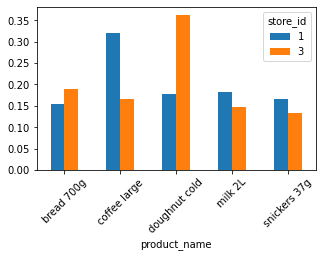

In [8]:
#Expected output is a barplot that shows the relative sales of the different products for two stores

pivot_df = pandas_df.pivot_table(index='product_name', columns='store_id',
                                 values='relative_sales')
# plot
pivot_df.plot(kind='bar', figsize=(5, 3), rot=0)

plt.xticks(rotation=45)

plt.show()